In [1]:
import csv
import time
import os
from sys import getsizeof

import numpy as np
import random
import pandas as pd
from matplotlib import pyplot as plt

In [2]:
# в задании не сказано про выпуклость зон ресторанов
# попробуем сделать с произвольной зоной
# для начала сгенерируем данные

In [3]:
generated_places_path = 'generated_place_zone.csv'
generated_users_path = 'generated_user_coordinates.csv'

def gen_places(n_polygons, canvas_size, filename):
    with open(filename, 'w', newline='\n') as file:
        writer = csv.writer(file)
        for i in range(n_polygons):    
            center = np.random.uniform(low=0, high=canvas_size, size=2)
            writer.writerow([
                i,
                center[0] + random.random() - 0.5,
                center[1] + random.random() - 0.5,
                0
            ])
            writer.writerow([
                i,
                center[0] + random.random() + 0.5,
                center[1] + random.random() - 0.5,
                1
            ])
            writer.writerow([
                i,
                center[0] + random.random() + 0.5,
                center[1] + random.random() + 0.5,
                2
            ])
            writer.writerow([
                i,
                center[0] + random.random() - 0.5,
                center[1] + random.random() + 0.5,
                3
            ])
        
def gen_users(nrows, canvas_size, filename):
    with open(filename, 'w', newline='\n') as file:
        writer = csv.writer(file)
        for i in range(nrows):
            writer.writerow([
                i,
                *np.random.uniform(low=0, high=canvas_size, size=2)
            ])

In [4]:
n_rows_users = 300000
n_rows_places = 500000

n_polygons = n_rows_places//4
canvas_size = np.sqrt(n_polygons/1.25)

gen_places(n_polygons, canvas_size, generated_places_path)
gen_users(n_rows_users, canvas_size, generated_users_path)

In [5]:
print("Places size: {:.2f} mb".format(os.path.getsize(generated_places_path)/1024**2))
print("Users size: {:.2f} mb".format(os.path.getsize(generated_users_path)/1024**2))

Places size: 21.97 mb
Users size: 12.76 mb


In [6]:
# вполне приемлемый объем памяти для загрузки файлов целиком

In [7]:
def get_user(filename):
    with open(filename, 'r') as file:
        reader = csv.reader(file)
        for row in reader:
            yield np.transpose(np.array(row).astype(float))

def get_place(filename):
    with open(filename, 'r') as file:
        reader = csv.reader(file)
        data = []
        for row in reader:
            if data and int(row[3]) == 0:
                yield np.transpose(np.array(data))
                data = []
                data.append(np.array(row).astype(float))
            else:
                data.append(np.array(row).astype(float))

In [8]:
users = []
for user in get_user(generated_users_path):
    users.append(user)
users = np.array(users)

places = []
for place in get_place(generated_places_path):
    places.append(place)
places = np.array(places)

In [9]:
print("Places size: {:.2f} mb".format(getsizeof(places)/1024**2))
print("Users size: {:.2f} mb".format(getsizeof(users)/1024**2))

Places size: 15.26 mb
Users size: 6.87 mb


In [10]:
places[0]

array([[  0.        ,   0.        ,   0.        ,   0.        ],
       [  5.75426304,   7.20996466,   6.73598893,   6.42121111],
       [315.4217604 , 315.55870082, 316.0090231 , 316.60122527],
       [  0.        ,   1.        ,   2.        ,   3.        ]])

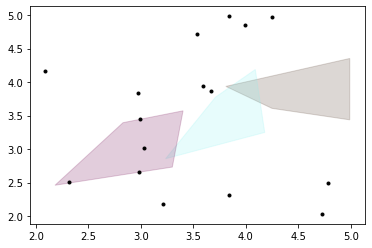

In [11]:
# посмотрим что получилось в зоне x \in (2,5), y \in (2,5)
places_to_plot = []
for place in places:
    place_id, y, x, point_nums = place
    if 2 < min(x) < 4:
        if 2 < min(y) < 4:
            places_to_plot.append(place)
            
users_to_plot = []
for user in users:
    user_id, y, x = user
    if 2 < x < 5:
        if 2 < y < 5:
            users_to_plot.append(user)

gen_color = lambda: np.random.choice(255, size=3)/255

# случаыные зоны
for i, item in enumerate(places_to_plot):
    loc_id, y, x, point_num = item
    color = gen_color()
    plt.plot(x, y, marker='', linestyle='', color=color)
    plt.fill(x, y, color=np.append(color, 0.2))
    if i >= 15:
        break

# случайные пользователи
for i, item in enumerate(users_to_plot):
    point_id, y, x = item
    plt.plot(x, y, marker='.', color='black')
#     plt.annotate(int(point_id), (x+0.01, y+0.01))
    if i >= 15:
        break

In [12]:
# идея следующая:
# 1. preprocessing
# 1.1 генерируем сетку для всего пространства
# пусть размер сетки будет max(width), max(height)
# где width и height соответственно ширина и высота bounding box всех полигонов
# 1.2
# дополняем данные переменной grid, где хранятся данные о наличии в каждой клетке
# пользователей и полигонов по их id
# таким образом для каждого пользователя есть определенный набор "кандидатов"
# среди полигонов, которые расположены в той же клетке сетки
# таким образом мы избегаем квадратичной сложности алгоритма
# (создание сетки и определение пользователей и полигонов в клетки -> O(n), где n-число координат)
# 2
# для каждого пользователя и для всех полигонов в его клетке определяем
# находится ли пользователь внутри полигона
# определяем по методу трассировки луча -> O(n), где n - число вершин полигона
# Общая сложность алгоритма -> O(n_users*m*n_point), где n_users-число пользователей,
# m-среднее количество полигонов в клетке, n_points - среднее число вершин в полигоне

In [13]:
# 1. сортировка places

In [14]:
places[0]

array([[  0.        ,   0.        ,   0.        ,   0.        ],
       [  5.75426304,   7.20996466,   6.73598893,   6.42121111],
       [315.4217604 , 315.55870082, 316.0090231 , 316.60122527],
       [  0.        ,   1.        ,   2.        ,   3.        ]])

In [15]:
places_preprocessed = []

for i, place in enumerate(places):
    # добавляем координаты bounding box
    place = np.append(
        place,
        np.array([
            [min(place[1])]*4,
            [max(place[1])]*4,
            [min(place[2])]*4,
            [max(place[2])]*4,
        ]),
        axis=0)
    # добавляем высоту и ширину bounding box
    place = np.append(
        place,
        np.array([
            [(place[5][0] - place[4][0])]*4,
            [(place[7][0] - place[6][0])]*4
        ]),
        axis=0
    )
    
    places_preprocessed.append(place)
    
places_preprocessed = np.array(places_preprocessed)

In [16]:
# [
#     place_id,
#     y points,
#     x points,
#     point_nums,
#     min(y),
#     max(y),
#     min(x),
#     max(x),
#     height,
#     width
# ]
places_preprocessed[0]

array([[  0.        ,   0.        ,   0.        ,   0.        ],
       [  5.75426304,   7.20996466,   6.73598893,   6.42121111],
       [315.4217604 , 315.55870082, 316.0090231 , 316.60122527],
       [  0.        ,   1.        ,   2.        ,   3.        ],
       [  5.75426304,   5.75426304,   5.75426304,   5.75426304],
       [  7.20996466,   7.20996466,   7.20996466,   7.20996466],
       [315.4217604 , 315.4217604 , 315.4217604 , 315.4217604 ],
       [316.60122527, 316.60122527, 316.60122527, 316.60122527],
       [  1.45570162,   1.45570162,   1.45570162,   1.45570162],
       [  1.17946487,   1.17946487,   1.17946487,   1.17946487]])

In [17]:
# считаем ширину и длину клетки в сетке
grid_width = np.ceil(max(places_preprocessed[:,9,0]))
grid_height = np.ceil(max(places_preprocessed[:,8,0]))

In [18]:
# приводим данные к центру от 0 по x и y
x_min = min(places_preprocessed[:,6,0])
y_min = min(places_preprocessed[:,4,0])

for i in range(len(places_preprocessed)):
    places_preprocessed[i][[2,6,7],:] -= x_min
    places_preprocessed[i][[1,4,5],:] -= y_min
    
for i in range(len(users)):
    users[i][2] -= x_min
    users[i][1] -= y_min

In [19]:
places_preprocessed[0]

array([[  0.        ,   0.        ,   0.        ,   0.        ],
       [  6.20839996,   7.66410158,   7.19012585,   6.87534803],
       [315.86911907, 316.00605949, 316.45638177, 317.04858394],
       [  0.        ,   1.        ,   2.        ,   3.        ],
       [  6.20839996,   6.20839996,   6.20839996,   6.20839996],
       [  7.66410158,   7.66410158,   7.66410158,   7.66410158],
       [315.86911907, 315.86911907, 315.86911907, 315.86911907],
       [317.04858394, 317.04858394, 317.04858394, 317.04858394],
       [  1.45570162,   1.45570162,   1.45570162,   1.45570162],
       [  1.17946487,   1.17946487,   1.17946487,   1.17946487]])

In [20]:
grid_x_len = max(places_preprocessed[:,6,0]) // grid_width + 1
grid_y_len = max(places_preprocessed[:,4,0]) // grid_height + 1

In [21]:
grid = [
    [
        {
            'places': set(),
            'users': set()
        } for _ in range(int(grid_y_len + 1))
    ] for _ in range(int(grid_x_len + 1))
]

In [22]:
# заполняем сетку через добавление в множества каждой клетки id полигонов
# смотрим принадлежность по краям bounding box
for i, polygon in enumerate(places_preprocessed):
    min_x_cell = polygon[6][0] // grid_width
    max_x_cell = polygon[7][0] // grid_width
    min_y_cell = polygon[4][0] // grid_height
    max_y_cell = polygon[5][0] // grid_height
    grid[int(min_x_cell)][int(min_y_cell)]['places'].add(int(polygon[0][0]))
    grid[int(min_x_cell)][int(max_y_cell)]['places'].add(int(polygon[0][0]))
    grid[int(max_x_cell)][int(min_y_cell)]['places'].add(int(polygon[0][0]))
    grid[int(max_x_cell)][int(max_y_cell)]['places'].add(int(polygon[0][0]))
    print(i, end='\r')

In [23]:
# -//- для пользователей
for i, user in enumerate(users):
    user_id, y, x = user
    x_cell = x // grid_width
    y_cell = y // grid_height
    grid[int(x_cell)][int(y_cell)]['users'].add(int(user_id))
    print(i, end='\r')

2114

3790

5496

In [24]:
# нарисуем что получилось
def get_grid_lines(x_cell, y_cell):
    x_offset_left = 0.5*grid_width if not x_cell == 0 else 0
    x_offset_right = 0.5*grid_width if not x_cell == grid_x_len else 0
    y_offset_bottom = 0.5*grid_height if not y_cell == 0 else 0
    y_offset_top = 0.5*grid_height if not y_cell == grid_y_len else 0
    vertical_lines = [
        [
            [grid_width*x_cell, grid_width*x_cell],
            [grid_height*y_cell - y_offset_bottom, grid_height*(y_cell + 1) + y_offset_top]
        ],
        [
            [grid_width*(x_cell + 1), grid_width*(x_cell + 1)],
            [grid_height*y_cell - y_offset_bottom, grid_height*(y_cell + 1) + y_offset_top]
        ]
    ]
    horizontal_lines = [
        [
            [grid_width*x_cell - x_offset_left, grid_width*(x_cell + 1) + x_offset_right],
            [grid_height*y_cell, grid_height*y_cell],
        ],
        [
            [grid_width*x_cell - x_offset_left, grid_width*(x_cell + 1) + x_offset_right],
            [grid_height*(y_cell + 1), grid_height*(y_cell + 1)]
        ]
    ]
    return [*vertical_lines, *horizontal_lines]

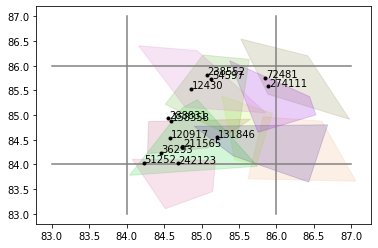

In [32]:
x_cell = 42
y_cell = 42

places_to_plot = places_preprocessed[list(grid[x_cell][y_cell]['places'])]
users_to_plot = users[list(grid[x_cell][y_cell]['users'])]

for line in get_grid_lines(x_cell, y_cell):
    # рисуем сетку
    x, y = line
    plt.plot(x, y, color='grey')
    
for place in places_to_plot:
    # рисуем пользователей
    color = gen_color()
    plt.plot(place[2], place[1], marker='', linestyle='', color=color)
    plt.fill(place[2], place[1], color=np.append(color, 0.2))
    
for user in users_to_plot:
    point_id, y, x = user
    plt.plot(x, y, marker='.', color='black')
    plt.annotate(int(point_id), (x+0.01, y+0.01))

In [33]:
# метод трассировки луча

In [34]:
def is_inside(user, polygon):
    y = polygon[1]
    x = polygon[2]
    # находим линии
    lines = []
    for i in range(len(x)):
        lines.append([
            [x[i-1], x[i]],
            [y[i-1], y[i]]
        ])
    crossings = 0
    for line in lines:
        line_x, line_y = line
        if is_crossing(user[2], user[1], line_x, line_y):
            crossings += 1
    if crossings%2 == 1:
        return True
    return False

In [35]:
def is_crossing(x, y, x_line, y_line):
    # координаты "луча" - отрезка, длиной 2*grid width
    x1_1, y1_1 = x, y
    x1_2, y1_2 = x + 2*grid_width, y
    # координаты отрезка
    x2_1, y2_1 = x_line[0], y_line[0]
    x2_2, y2_2 = x_line[1], y_line[1]
    
    if y2_2 == y2_1:
        if y2_1 == y1_1:
            return True
        else:
            return False
    
    if min((y2_1, y2_2)) <= y1_1 and max((y2_1, y2_2)) >= y1_1:
        if min((x2_1, x2_2)) <= max((x1_1, x1_2)) and max((x2_1, x2_2)) >= min((x1_1, x1_2)):
            coef = (y2_2 - y2_1)/(x2_2 - x2_1)
            const = y2_1 - x2_1*coef
            if (y1_1 - const)/coef >= min((x1_1, x1_2)):
                return True
    return False

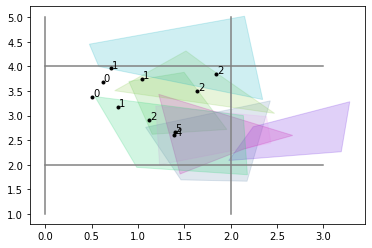

In [36]:
x_cell = 0
y_cell = 1

places_to_plot = places_preprocessed[list(grid[x_cell][y_cell]['places'])]
users_to_plot = users[list(grid[x_cell][y_cell]['users'])]

for line in get_grid_lines(x_cell, y_cell):
    # рисуем сетку
    x, y = line
    plt.plot(x, y, color='grey')
    
for place in places_to_plot:
    # рисуем пользователей
    color = gen_color()
    plt.plot(place[2], place[1], marker='', linestyle='', color=color)
    plt.fill(place[2], place[1], color=np.append(color, 0.2))
    
for user in users_to_plot:
    point_id, y, x = user
    plt.plot(x, y, marker='.', color='black')
    count = 0
    for place in places_to_plot:
        if is_inside(user, place):
            count += 1
    plt.annotate(count, (x+0.01, y+0.01))

In [37]:
users_output = [
    [user[0], 0] for user in users
]

In [38]:
users_preprocessed = []
for user in users:
    users_preprocessed.append([
        *user,
        int(user[1] // grid_height),
        int(user[2] // grid_width)
    ])

In [39]:
# [
#     user_id,
#     y,
#     x,
#     y_cell,
#     x_cell
# ]
users_preprocessed[0]

[0.0, 9.278300551659106, 170.88494890086446, 4, 85]

In [40]:
for i, user in enumerate(users_preprocessed):
    for place in places_preprocessed[list(grid[user[4]][user[3]]['places'])]:
        if is_inside(user, place):
            users_output[i][1] += 1
    if i % 10000 == 0:
        print(i, end='\r')

users_output = np.array(users_output)

***

In [41]:
# результат

array([[175616,      1],
       [ 97737,      1],
       [137435,      2],
       [155666,      1],
       [ 85592,      2],
       [190105,      5],
       [259258,      0],
       [121627,      0],
       [277116,      4],
       [ 26847,      2]])

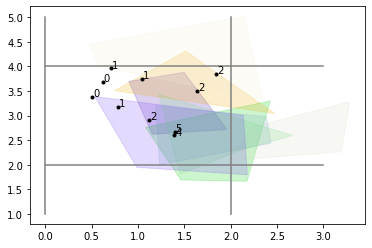

In [42]:
x_cell = 0
y_cell = 1

places_to_plot = places_preprocessed[list(grid[x_cell][y_cell]['places'])]
users_to_plot = users[list(grid[x_cell][y_cell]['users'])]

for line in get_grid_lines(x_cell, y_cell):
    # рисуем сетку
    x, y = line
    plt.plot(x, y, color='grey')
    
for place in places_to_plot:
    # рисуем пользователей
    color = gen_color()
    plt.plot(place[2], place[1], marker='', linestyle='', color=color)
    plt.fill(place[2], place[1], color=np.append(color, 0.2))
    
for user in users_to_plot:
    point_id, y, x = user
    plt.plot(x, y, marker='.', color='black')
    count = 0
    for place in places_to_plot:
        if is_inside(user, place):
            count += 1
    plt.annotate(count, (x+0.01, y+0.01))

users_output[users_to_plot[:,0].astype(int)].astype(int)

In [43]:
# можно улучшить 1. оптимизировав сетку, 2. распараллелив вычисления